# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

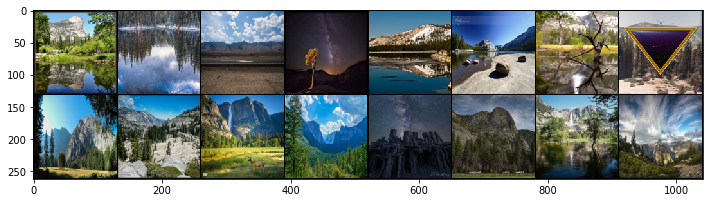

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

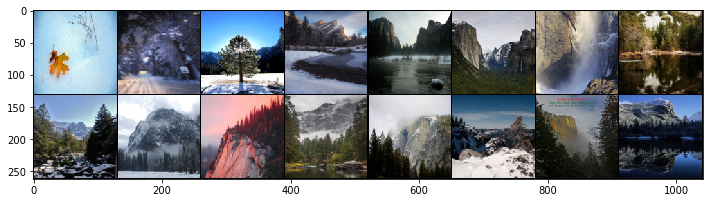

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0078)
Max:  tensor(0.9843)


In [7]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9843)
Scaled max:  tensor(0.9686)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value
        self.conv1 = conv(3,          conv_dim,   4, stride=2, padding=1, batch_norm=False) #128 -> 64
        self.conv2 = conv(conv_dim,   conv_dim*2, 4, stride=2, padding=1, batch_norm=True)  #64  -> 32
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, stride=2, padding=1, batch_norm=True)  #32  -> 16
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, stride=2, padding=1, batch_norm=True)  #16  -> 8
        self.conv5 = conv(conv_dim*8, 1         , 8, stride=1, padding=0, batch_norm=False) #8   -> 1 #udacity video has kernel size = 4 here
        
    def forward(self, x):
        # define feedforward behavior
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs  
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        self.conv1 = conv(conv_dim, conv_dim, 3, stride=1, padding=1, batch_norm=True)
        self.conv2 = conv(conv_dim, conv_dim, 3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        x_block = F.relu(self.conv1(x))
        x_block = self.conv2(x_block)
        
        x = x + x_block
        
        return x
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [13]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()
        self.n_res_blocks = n_res_blocks
        
        # 1. Define the encoder part of the generator
        self.conv1 = conv(3,          conv_dim*1, 4, stride=2, padding=1, batch_norm=True) #128 -> 64
        self.conv2 = conv(conv_dim*1, conv_dim*2, 4, stride=2, padding=1, batch_norm=True) # 64 -> 32
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, stride=2, padding=1, batch_norm=True) # 32 -> 16
        
        # 2. Define the resnet part of the generator
        res_blocks_list = []
        for i in range(n_res_blocks):
            res_blocks_list.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_blocks_list)
        
        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4, stride=2, padding=1, batch_norm=True)  #16 -> 32
        self.deconv2 = deconv(conv_dim*2, conv_dim*1, 4, stride=2, padding=1, batch_norm=True)  #32 -> 64
        self.deconv3 = deconv(conv_dim*1, 3,          4, stride=2, padding=1, batch_norm=False) #64 -> 128

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        #print("Input shape into conv1: {}".format(x.shape))
        x = F.relu(self.conv1(x))
        #print("Input shape into conv2: {}".format(x.shape))
        x = F.relu(self.conv2(x))
        #print("Input shape into conv3: {}".format(x.shape))
        x = F.relu(self.conv3(x))
        
        x = self.res_blocks(x)  #no relu for you!
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        
        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [15]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [16]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
 

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    mse_loss = torch.mean((D_out-1)**2)
    return mse_loss

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    mse_loss = torch.mean((D_out-0)**2)
    return mse_loss

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    loss = lambda_weight * torch.mean(torch.abs(real_im - reconstructed_im))
    return loss
    

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr=0.0002
beta1=0.5
beta2=0.99

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [19]:
# import save code
from helpers import save_samples, checkpoint

In [30]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=100):
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        discriminator_out_X_real = D_X(images_X)
        D_X_loss_real = real_mse_loss(discriminator_out_X_real)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_images_X = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        discriminator_out_X_fake = D_X(fake_images_X)
        D_X_fake_loss = fake_mse_loss(discriminator_out_X_fake)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_loss_real + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        
        ##   Second: D_Y, real and fake loss components   ##
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real Y images
        discriminator_out_Y_real = D_Y(images_Y)
        D_Y_loss_real = real_mse_loss(discriminator_out_Y_real)
        
        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_images_Y = G_XtoY(images_X)
                
        # 3. Compute the fake loss for D_Y
        discriminator_out_Y_fake = D_Y(fake_images_Y)
        D_Y_fake_loss = fake_mse_loss(discriminator_out_Y_fake)
        
        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_loss_real + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()
        
        

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_images_X = G_YtoX(images_Y)
                
        # 2. Compute the generator loss based on domain X
        discriminator_out_fake = D_X(fake_images_X)
        g_YtoX_loss = fake_mse_loss(discriminator_out_fake)
        
        # 3. Create a reconstructed y
        reconstructed_images_y = G_XtoY(fake_images_X)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        cycle_consistency_loss_Y = cycle_consistency_loss(images_Y, reconstructed_images_y, 10.0)

        
        ##    Second: generate fake Y images and reconstructed X images    ##
        
        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_images_Y = G_XtoY(images_X)
        
        # 2. Compute the generator loss based on domain Y
        discriminator_out_real = D_Y(fake_images_Y)
        g_XtoY_loss = real_mse_loss(discriminator_out_real)
        
        # 3. Create a reconstructed x
        reconstructed_images_X = G_YtoX(fake_images_Y)
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        cycle_consistency_loss_X = cycle_consistency_loss(images_X, reconstructed_images_X, 10.0)
            
        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + cycle_consistency_loss_X + cycle_consistency_loss_Y
        g_total_loss.backward()
        g_optimizer.step()
        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [37]:
n_epochs = 4000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.0046 | d_Y_loss: 0.1036 | g_total_loss: 3.8112
Epoch [   20/ 4000] | d_X_loss: 0.0020 | d_Y_loss: 0.1633 | g_total_loss: 2.7972
Epoch [   30/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.2160 | g_total_loss: 2.6807
Epoch [   40/ 4000] | d_X_loss: 0.0049 | d_Y_loss: 0.3783 | g_total_loss: 2.9627
Epoch [   50/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0629 | g_total_loss: 3.8252
Epoch [   60/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.2312 | g_total_loss: 3.0352
Epoch [   70/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.0765 | g_total_loss: 3.2349
Epoch [   80/ 4000] | d_X_loss: 0.0027 | d_Y_loss: 0.1037 | g_total_loss: 3.4884
Epoch [   90/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0878 | g_total_loss: 3.5661


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0622 | g_total_loss: 3.3303


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.0028 | d_Y_loss: 0.0687 | g_total_loss: 3.5878
Epoch [  120/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0949 | g_total_loss: 3.5268
Epoch [  130/ 4000] | d_X_loss: 0.0016 | d_Y_loss: 0.1813 | g_total_loss: 5.2496
Epoch [  140/ 4000] | d_X_loss: 0.0024 | d_Y_loss: 0.1593 | g_total_loss: 3.6026
Epoch [  150/ 4000] | d_X_loss: 0.0034 | d_Y_loss: 0.1393 | g_total_loss: 4.5096
Epoch [  160/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0992 | g_total_loss: 4.0590
Epoch [  170/ 4000] | d_X_loss: 0.0025 | d_Y_loss: 0.2024 | g_total_loss: 4.5127
Epoch [  180/ 4000] | d_X_loss: 0.0025 | d_Y_loss: 0.1685 | g_total_loss: 4.4412
Epoch [  190/ 4000] | d_X_loss: 0.0034 | d_Y_loss: 0.1265 | g_total_loss: 3.4757


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.0051 | d_Y_loss: 0.2298 | g_total_loss: 2.9247


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.1558 | g_total_loss: 4.4520
Epoch [  220/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0872 | g_total_loss: 4.5267
Epoch [  230/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.2194 | g_total_loss: 4.5282
Epoch [  240/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.2540 | g_total_loss: 5.5385
Epoch [  250/ 4000] | d_X_loss: 0.0020 | d_Y_loss: 0.1368 | g_total_loss: 2.7969
Epoch [  260/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.2423 | g_total_loss: 4.8669
Epoch [  270/ 4000] | d_X_loss: 0.0019 | d_Y_loss: 0.1822 | g_total_loss: 3.8671
Epoch [  280/ 4000] | d_X_loss: 0.0309 | d_Y_loss: 0.1270 | g_total_loss: 3.5710
Epoch [  290/ 4000] | d_X_loss: 0.0083 | d_Y_loss: 0.3572 | g_total_loss: 2.6589


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.1278 | g_total_loss: 3.7838


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.0036 | d_Y_loss: 0.2206 | g_total_loss: 3.1913
Epoch [  320/ 4000] | d_X_loss: 0.0241 | d_Y_loss: 0.1454 | g_total_loss: 4.2107
Epoch [  330/ 4000] | d_X_loss: 0.0034 | d_Y_loss: 0.1280 | g_total_loss: 4.2784
Epoch [  340/ 4000] | d_X_loss: 0.0131 | d_Y_loss: 0.1270 | g_total_loss: 3.7995
Epoch [  350/ 4000] | d_X_loss: 0.0052 | d_Y_loss: 0.1717 | g_total_loss: 2.5245
Epoch [  360/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.7998 | g_total_loss: 3.1169
Epoch [  370/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.1278 | g_total_loss: 3.6109
Epoch [  380/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0868 | g_total_loss: 3.5287
Epoch [  390/ 4000] | d_X_loss: 0.0048 | d_Y_loss: 0.1021 | g_total_loss: 4.5255


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.0904 | g_total_loss: 3.2933


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1116 | g_total_loss: 4.0198
Epoch [  420/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.1031 | g_total_loss: 3.4350
Epoch [  430/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.2605 | g_total_loss: 3.2758
Epoch [  440/ 4000] | d_X_loss: 0.0037 | d_Y_loss: 0.0679 | g_total_loss: 4.1221
Epoch [  450/ 4000] | d_X_loss: 0.0063 | d_Y_loss: 0.2386 | g_total_loss: 5.4971
Epoch [  460/ 4000] | d_X_loss: 0.0026 | d_Y_loss: 0.0492 | g_total_loss: 3.3392
Epoch [  470/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1558 | g_total_loss: 3.6110
Epoch [  480/ 4000] | d_X_loss: 0.0070 | d_Y_loss: 0.0533 | g_total_loss: 3.8096
Epoch [  490/ 4000] | d_X_loss: 0.0053 | d_Y_loss: 0.0870 | g_total_loss: 4.0169


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.3299 | g_total_loss: 3.9552


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.0038 | d_Y_loss: 0.5381 | g_total_loss: 7.3694
Epoch [  520/ 4000] | d_X_loss: 0.0536 | d_Y_loss: 0.2079 | g_total_loss: 2.7206
Epoch [  530/ 4000] | d_X_loss: 0.0039 | d_Y_loss: 0.0868 | g_total_loss: 3.5058
Epoch [  540/ 4000] | d_X_loss: 0.0058 | d_Y_loss: 0.3356 | g_total_loss: 5.1409
Epoch [  550/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.1155 | g_total_loss: 3.3659
Epoch [  560/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.0691 | g_total_loss: 3.9149
Epoch [  570/ 4000] | d_X_loss: 0.0016 | d_Y_loss: 0.0789 | g_total_loss: 3.2259
Epoch [  580/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0978 | g_total_loss: 4.3498
Epoch [  590/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0851 | g_total_loss: 3.3352


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.1683 | g_total_loss: 4.6244


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.0557 | d_Y_loss: 0.0623 | g_total_loss: 3.8523
Epoch [  620/ 4000] | d_X_loss: 0.0495 | d_Y_loss: 0.1199 | g_total_loss: 3.7688
Epoch [  630/ 4000] | d_X_loss: 0.0053 | d_Y_loss: 0.0777 | g_total_loss: 3.6890
Epoch [  640/ 4000] | d_X_loss: 0.0104 | d_Y_loss: 0.1328 | g_total_loss: 3.1014
Epoch [  650/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.5496 | g_total_loss: 2.5466
Epoch [  660/ 4000] | d_X_loss: 0.0075 | d_Y_loss: 0.1831 | g_total_loss: 4.7335
Epoch [  670/ 4000] | d_X_loss: 0.0022 | d_Y_loss: 0.0779 | g_total_loss: 3.7105
Epoch [  680/ 4000] | d_X_loss: 0.0064 | d_Y_loss: 0.0880 | g_total_loss: 3.5718
Epoch [  690/ 4000] | d_X_loss: 0.0035 | d_Y_loss: 0.1303 | g_total_loss: 3.9158


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 4000] | d_X_loss: 0.0020 | d_Y_loss: 0.1860 | g_total_loss: 4.4238


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.0022 | d_Y_loss: 0.2046 | g_total_loss: 2.7632
Epoch [  720/ 4000] | d_X_loss: 0.0019 | d_Y_loss: 0.0815 | g_total_loss: 3.1353
Epoch [  730/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0784 | g_total_loss: 4.3220
Epoch [  740/ 4000] | d_X_loss: 0.0046 | d_Y_loss: 0.1033 | g_total_loss: 3.4056
Epoch [  750/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0725 | g_total_loss: 3.4653
Epoch [  760/ 4000] | d_X_loss: 0.0026 | d_Y_loss: 0.2959 | g_total_loss: 2.1615
Epoch [  770/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 1.2396 | g_total_loss: 3.0336
Epoch [  780/ 4000] | d_X_loss: 0.0018 | d_Y_loss: 0.0642 | g_total_loss: 2.8144
Epoch [  790/ 4000] | d_X_loss: 0.0027 | d_Y_loss: 0.1370 | g_total_loss: 2.9658


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 4000] | d_X_loss: 0.0020 | d_Y_loss: 0.0761 | g_total_loss: 3.3813


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.0111 | d_Y_loss: 0.1584 | g_total_loss: 2.8231
Epoch [  820/ 4000] | d_X_loss: 0.0049 | d_Y_loss: 0.1971 | g_total_loss: 4.4774
Epoch [  830/ 4000] | d_X_loss: 0.0028 | d_Y_loss: 0.1846 | g_total_loss: 2.7872
Epoch [  840/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.1462 | g_total_loss: 4.6313
Epoch [  850/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.1254 | g_total_loss: 3.2566
Epoch [  860/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1015 | g_total_loss: 3.3896
Epoch [  870/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.0974 | g_total_loss: 3.9314
Epoch [  880/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.4182 | g_total_loss: 2.5818
Epoch [  890/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.1122 | g_total_loss: 3.5116


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1215 | g_total_loss: 3.7544


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.0105 | d_Y_loss: 0.1057 | g_total_loss: 4.2433
Epoch [  920/ 4000] | d_X_loss: 0.0019 | d_Y_loss: 0.2977 | g_total_loss: 5.2368
Epoch [  930/ 4000] | d_X_loss: 0.0019 | d_Y_loss: 0.0709 | g_total_loss: 3.7288
Epoch [  940/ 4000] | d_X_loss: 0.0022 | d_Y_loss: 0.5765 | g_total_loss: 2.6814
Epoch [  950/ 4000] | d_X_loss: 0.0117 | d_Y_loss: 0.1763 | g_total_loss: 4.8015
Epoch [  960/ 4000] | d_X_loss: 0.0044 | d_Y_loss: 0.1744 | g_total_loss: 3.2218
Epoch [  970/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.1800 | g_total_loss: 3.2054
Epoch [  980/ 4000] | d_X_loss: 0.0016 | d_Y_loss: 0.1366 | g_total_loss: 3.4032
Epoch [  990/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.1482 | g_total_loss: 3.2420


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.0943 | g_total_loss: 3.0115
Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.0136 | d_Y_loss: 0.0733 | g_total_loss: 3.5049
Epoch [ 1020/ 4000] | d_X_loss: 0.0020 | d_Y_loss: 0.1088 | g_total_loss: 3.7554
Epoch [ 1030/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1592 | g_total_loss: 4.1805
Epoch [ 1040/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.1891 | g_total_loss: 2.8441
Epoch [ 1050/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.1774 | g_total_loss: 3.8641
Epoch [ 1060/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.2994 | g_total_loss: 5.5585
Epoch [ 1070/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.1450 | g_total_loss: 2.7603
Epoch [ 1080/ 4000] | d_X_loss: 0.0051 | d_Y_loss: 0.2062 | g_total_loss: 2.7967
Epoch [ 1090/ 4000] | d_X_loss: 0.0019 | d_Y_loss: 0.1179 | g_total_loss: 3.8156


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.3050 | d_Y_loss: 0.0936 | g_total_loss: 3.0167


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.0022 | d_Y_loss: 0.0754 | g_total_loss: 3.4015
Epoch [ 1120/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.1295 | g_total_loss: 2.9990
Epoch [ 1130/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0904 | g_total_loss: 3.3374
Epoch [ 1140/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0605 | g_total_loss: 3.4663
Epoch [ 1150/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1831 | g_total_loss: 3.6093
Epoch [ 1160/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.1246 | g_total_loss: 2.9236
Epoch [ 1170/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.2544 | g_total_loss: 4.2768
Epoch [ 1180/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1341 | g_total_loss: 3.4938
Epoch [ 1190/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.1309 | g_total_loss: 3.0269


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1311 | g_total_loss: 4.0704


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1227 | g_total_loss: 2.8189
Epoch [ 1220/ 4000] | d_X_loss: 0.0041 | d_Y_loss: 0.1195 | g_total_loss: 3.0491
Epoch [ 1230/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.2733 | g_total_loss: 2.5162
Epoch [ 1240/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.2193 | g_total_loss: 3.7921
Epoch [ 1250/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0631 | g_total_loss: 2.9959
Epoch [ 1260/ 4000] | d_X_loss: 0.0014 | d_Y_loss: 0.0944 | g_total_loss: 4.4053
Epoch [ 1270/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.1421 | g_total_loss: 3.4516
Epoch [ 1280/ 4000] | d_X_loss: 0.0014 | d_Y_loss: 0.0758 | g_total_loss: 4.5056
Epoch [ 1290/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.2063 | g_total_loss: 4.7464


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 4000] | d_X_loss: 0.0212 | d_Y_loss: 0.0805 | g_total_loss: 3.1180


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0519 | g_total_loss: 2.9935
Epoch [ 1320/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.1494 | g_total_loss: 3.6553
Epoch [ 1330/ 4000] | d_X_loss: 0.0014 | d_Y_loss: 0.1094 | g_total_loss: 3.9142
Epoch [ 1340/ 4000] | d_X_loss: 0.0263 | d_Y_loss: 0.2191 | g_total_loss: 3.7791
Epoch [ 1350/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.1025 | g_total_loss: 3.7663
Epoch [ 1360/ 4000] | d_X_loss: 0.0045 | d_Y_loss: 0.0698 | g_total_loss: 3.6634
Epoch [ 1370/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.1938 | g_total_loss: 2.9267
Epoch [ 1380/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.0611 | g_total_loss: 2.9982
Epoch [ 1390/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0924 | g_total_loss: 3.6365


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1301 | g_total_loss: 2.9989


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.0032 | d_Y_loss: 0.0696 | g_total_loss: 3.4931
Epoch [ 1420/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0906 | g_total_loss: 3.3999
Epoch [ 1430/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.1063 | g_total_loss: 3.0112
Epoch [ 1440/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0857 | g_total_loss: 3.5562
Epoch [ 1450/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.1235 | g_total_loss: 3.7100
Epoch [ 1460/ 4000] | d_X_loss: 0.0077 | d_Y_loss: 0.0716 | g_total_loss: 3.8659
Epoch [ 1470/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1501 | g_total_loss: 3.6632
Epoch [ 1480/ 4000] | d_X_loss: 0.0043 | d_Y_loss: 0.0469 | g_total_loss: 3.4070
Epoch [ 1490/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.0907 | g_total_loss: 4.4864


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 4000] | d_X_loss: 0.0064 | d_Y_loss: 0.0635 | g_total_loss: 4.1789


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.0035 | d_Y_loss: 0.0850 | g_total_loss: 4.6231
Epoch [ 1520/ 4000] | d_X_loss: 0.0151 | d_Y_loss: 0.0547 | g_total_loss: 3.8974
Epoch [ 1530/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.2969 | g_total_loss: 2.8267
Epoch [ 1540/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.0810 | g_total_loss: 4.1086
Epoch [ 1550/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.1545 | g_total_loss: 3.2243
Epoch [ 1560/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0583 | g_total_loss: 3.7409
Epoch [ 1570/ 4000] | d_X_loss: 0.0024 | d_Y_loss: 0.1380 | g_total_loss: 5.0113
Epoch [ 1580/ 4000] | d_X_loss: 0.0127 | d_Y_loss: 0.0610 | g_total_loss: 3.1350
Epoch [ 1590/ 4000] | d_X_loss: 0.0037 | d_Y_loss: 0.0886 | g_total_loss: 2.7792


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 4000] | d_X_loss: 0.0054 | d_Y_loss: 0.1250 | g_total_loss: 4.1961


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.1898 | g_total_loss: 3.4639
Epoch [ 1620/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0601 | g_total_loss: 3.3200
Epoch [ 1630/ 4000] | d_X_loss: 0.0081 | d_Y_loss: 0.1768 | g_total_loss: 4.9601
Epoch [ 1640/ 4000] | d_X_loss: 0.0018 | d_Y_loss: 0.0629 | g_total_loss: 2.9967
Epoch [ 1650/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.3143 | g_total_loss: 3.3438
Epoch [ 1660/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1441 | g_total_loss: 2.5276
Epoch [ 1670/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0546 | g_total_loss: 3.2136
Epoch [ 1680/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1319 | g_total_loss: 3.1741
Epoch [ 1690/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.2398 | g_total_loss: 3.9873


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0641 | g_total_loss: 3.0009


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.8200 | g_total_loss: 3.9131
Epoch [ 1720/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0479 | g_total_loss: 3.0699
Epoch [ 1730/ 4000] | d_X_loss: 0.0137 | d_Y_loss: 0.0702 | g_total_loss: 3.6194
Epoch [ 1740/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.0703 | g_total_loss: 3.2511
Epoch [ 1750/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0998 | g_total_loss: 3.5189
Epoch [ 1760/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0792 | g_total_loss: 2.9637
Epoch [ 1770/ 4000] | d_X_loss: 0.0021 | d_Y_loss: 0.0524 | g_total_loss: 2.9906
Epoch [ 1780/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0606 | g_total_loss: 3.3673
Epoch [ 1790/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0578 | g_total_loss: 3.0495


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0970 | g_total_loss: 3.7921


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.0026 | d_Y_loss: 0.1173 | g_total_loss: 2.9499
Epoch [ 1820/ 4000] | d_X_loss: 0.0067 | d_Y_loss: 0.0414 | g_total_loss: 3.1421
Epoch [ 1830/ 4000] | d_X_loss: 0.0029 | d_Y_loss: 0.3359 | g_total_loss: 2.4716
Epoch [ 1840/ 4000] | d_X_loss: 0.0021 | d_Y_loss: 0.0897 | g_total_loss: 3.6459
Epoch [ 1850/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.1417 | g_total_loss: 3.9303
Epoch [ 1860/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.0722 | g_total_loss: 2.9224
Epoch [ 1870/ 4000] | d_X_loss: 0.0030 | d_Y_loss: 0.1105 | g_total_loss: 4.2673
Epoch [ 1880/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0830 | g_total_loss: 2.9893
Epoch [ 1890/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.3879 | g_total_loss: 7.3188


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.0527 | g_total_loss: 3.4383


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.0249 | d_Y_loss: 0.2646 | g_total_loss: 2.8226
Epoch [ 1920/ 4000] | d_X_loss: 0.0109 | d_Y_loss: 0.2427 | g_total_loss: 2.8349
Epoch [ 1930/ 4000] | d_X_loss: 0.0026 | d_Y_loss: 0.0538 | g_total_loss: 3.4727
Epoch [ 1940/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.1834 | g_total_loss: 2.4305
Epoch [ 1950/ 4000] | d_X_loss: 0.0072 | d_Y_loss: 0.1031 | g_total_loss: 2.8492
Epoch [ 1960/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.1405 | g_total_loss: 3.0511
Epoch [ 1970/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0514 | g_total_loss: 3.0536
Epoch [ 1980/ 4000] | d_X_loss: 0.0016 | d_Y_loss: 0.1827 | g_total_loss: 2.9956
Epoch [ 1990/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.1063 | g_total_loss: 3.2435


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0854 | g_total_loss: 2.8813


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.0780 | g_total_loss: 3.2457
Epoch [ 2020/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0752 | g_total_loss: 3.8517
Epoch [ 2030/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0716 | g_total_loss: 3.5585
Epoch [ 2040/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.2355 | g_total_loss: 4.6925
Epoch [ 2050/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1531 | g_total_loss: 3.5631
Epoch [ 2060/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0651 | g_total_loss: 3.6974
Epoch [ 2070/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1008 | g_total_loss: 4.3697
Epoch [ 2080/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.2525 | g_total_loss: 2.4414
Epoch [ 2090/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.3704 | g_total_loss: 2.7013


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 4000] | d_X_loss: 0.0043 | d_Y_loss: 0.0367 | g_total_loss: 3.3462


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0573 | g_total_loss: 3.4770
Epoch [ 2120/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.4912 | g_total_loss: 6.6968
Epoch [ 2130/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0951 | g_total_loss: 2.8436
Epoch [ 2140/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0746 | g_total_loss: 3.4719
Epoch [ 2150/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.0596 | g_total_loss: 3.3880
Epoch [ 2160/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1485 | g_total_loss: 4.3526
Epoch [ 2170/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0943 | g_total_loss: 3.3637
Epoch [ 2180/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0834 | g_total_loss: 3.9058
Epoch [ 2190/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0798 | g_total_loss: 3.7932


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0848 | g_total_loss: 3.6250
Saved samples_cyclegan/sample-002200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.2868 | g_total_loss: 4.0276
Epoch [ 2220/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.0837 | g_total_loss: 2.9108
Epoch [ 2230/ 4000] | d_X_loss: 0.0073 | d_Y_loss: 0.0505 | g_total_loss: 2.8993
Epoch [ 2240/ 4000] | d_X_loss: 0.0234 | d_Y_loss: 0.1784 | g_total_loss: 2.2028
Epoch [ 2250/ 4000] | d_X_loss: 0.0088 | d_Y_loss: 0.0482 | g_total_loss: 3.3080
Epoch [ 2260/ 4000] | d_X_loss: 0.0029 | d_Y_loss: 0.1313 | g_total_loss: 4.3297
Epoch [ 2270/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0966 | g_total_loss: 3.6558
Epoch [ 2280/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.0646 | g_total_loss: 3.6868
Epoch [ 2290/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0558 | g_total_loss: 3.6688


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0613 | g_total_loss: 3.0520


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0584 | g_total_loss: 3.2040
Epoch [ 2320/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1577 | g_total_loss: 2.4002
Epoch [ 2330/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0767 | g_total_loss: 3.1751
Epoch [ 2340/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0934 | g_total_loss: 3.4606
Epoch [ 2350/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0495 | g_total_loss: 3.3504
Epoch [ 2360/ 4000] | d_X_loss: 0.0018 | d_Y_loss: 0.0612 | g_total_loss: 3.3218
Epoch [ 2370/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.2885 | g_total_loss: 4.1715
Epoch [ 2380/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.2876 | g_total_loss: 2.9055
Epoch [ 2390/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.1465 | g_total_loss: 4.1704


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0672 | g_total_loss: 3.0535


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0468 | g_total_loss: 3.7483
Epoch [ 2420/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0971 | g_total_loss: 2.9243
Epoch [ 2430/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0738 | g_total_loss: 3.4296
Epoch [ 2440/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.3454 | g_total_loss: 5.4408
Epoch [ 2450/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0831 | g_total_loss: 3.2219
Epoch [ 2460/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.2152 | g_total_loss: 2.7765
Epoch [ 2470/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0338 | g_total_loss: 3.1707
Epoch [ 2480/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.2167 | g_total_loss: 3.6430
Epoch [ 2490/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.0665 | g_total_loss: 3.4980


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.0224 | d_Y_loss: 0.1433 | g_total_loss: 3.8889


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.0045 | d_Y_loss: 0.0603 | g_total_loss: 3.1433
Epoch [ 2520/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.2840 | g_total_loss: 2.3810
Epoch [ 2530/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1013 | g_total_loss: 4.1799
Epoch [ 2540/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0573 | g_total_loss: 3.0150
Epoch [ 2550/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0792 | g_total_loss: 3.4210
Epoch [ 2560/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1642 | g_total_loss: 4.4932
Epoch [ 2570/ 4000] | d_X_loss: 0.0037 | d_Y_loss: 0.1223 | g_total_loss: 3.1840
Epoch [ 2580/ 4000] | d_X_loss: 0.0019 | d_Y_loss: 0.2249 | g_total_loss: 4.2066
Epoch [ 2590/ 4000] | d_X_loss: 0.0014 | d_Y_loss: 0.1026 | g_total_loss: 3.5261


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0447 | g_total_loss: 3.1830


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.1149 | g_total_loss: 2.9516
Epoch [ 2620/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1784 | g_total_loss: 4.5334
Epoch [ 2630/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.0310 | g_total_loss: 3.3825
Epoch [ 2640/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0695 | g_total_loss: 3.7789
Epoch [ 2650/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.2038 | g_total_loss: 2.6162
Epoch [ 2660/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0358 | g_total_loss: 3.2071
Epoch [ 2670/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0396 | g_total_loss: 2.9866
Epoch [ 2680/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0372 | g_total_loss: 3.5985
Epoch [ 2690/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1393 | g_total_loss: 3.9376


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0704 | g_total_loss: 2.8829


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.0025 | d_Y_loss: 0.1852 | g_total_loss: 3.9329
Epoch [ 2720/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.1408 | g_total_loss: 2.9080
Epoch [ 2730/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.0468 | g_total_loss: 3.0931
Epoch [ 2740/ 4000] | d_X_loss: 0.0048 | d_Y_loss: 0.1121 | g_total_loss: 3.5492
Epoch [ 2750/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1268 | g_total_loss: 4.2975
Epoch [ 2760/ 4000] | d_X_loss: 0.0056 | d_Y_loss: 0.0901 | g_total_loss: 2.6833
Epoch [ 2770/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0655 | g_total_loss: 3.5458
Epoch [ 2780/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0920 | g_total_loss: 2.9542
Epoch [ 2790/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0724 | g_total_loss: 3.0805


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1416 | g_total_loss: 3.4567


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1074 | g_total_loss: 3.6949
Epoch [ 2820/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1157 | g_total_loss: 2.8524
Epoch [ 2830/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0516 | g_total_loss: 3.4835
Epoch [ 2840/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0688 | g_total_loss: 3.3637
Epoch [ 2850/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.1809 | g_total_loss: 3.4688
Epoch [ 2860/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0909 | g_total_loss: 3.7732
Epoch [ 2870/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.1604 | g_total_loss: 3.7433
Epoch [ 2880/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0997 | g_total_loss: 3.0556
Epoch [ 2890/ 4000] | d_X_loss: 0.0046 | d_Y_loss: 0.0633 | g_total_loss: 3.0711


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.0707 | g_total_loss: 3.6229


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0507 | g_total_loss: 2.6916
Epoch [ 2920/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0538 | g_total_loss: 3.2820
Epoch [ 2930/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1052 | g_total_loss: 3.4426
Epoch [ 2940/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1694 | g_total_loss: 4.3888
Epoch [ 2950/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.0730 | g_total_loss: 3.6048
Epoch [ 2960/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0590 | g_total_loss: 2.9144
Epoch [ 2970/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.2736 | g_total_loss: 2.2466
Epoch [ 2980/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0650 | g_total_loss: 2.8443
Epoch [ 2990/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.4750 | g_total_loss: 2.4434


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0335 | g_total_loss: 3.2231


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.0192 | d_Y_loss: 0.0318 | g_total_loss: 3.1297
Epoch [ 3020/ 4000] | d_X_loss: 0.0153 | d_Y_loss: 0.0367 | g_total_loss: 3.1071
Epoch [ 3030/ 4000] | d_X_loss: 0.0392 | d_Y_loss: 0.0541 | g_total_loss: 3.3306
Epoch [ 3040/ 4000] | d_X_loss: 0.0015 | d_Y_loss: 0.0887 | g_total_loss: 3.6302
Epoch [ 3050/ 4000] | d_X_loss: 0.0017 | d_Y_loss: 0.0888 | g_total_loss: 3.0073
Epoch [ 3060/ 4000] | d_X_loss: 0.0018 | d_Y_loss: 0.2704 | g_total_loss: 2.5691
Epoch [ 3070/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0188 | g_total_loss: 3.3601
Epoch [ 3080/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0550 | g_total_loss: 3.4685
Epoch [ 3090/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0369 | g_total_loss: 3.1095


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1343 | g_total_loss: 2.5540


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1232 | g_total_loss: 3.2360
Epoch [ 3120/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0653 | g_total_loss: 3.0169
Epoch [ 3130/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0979 | g_total_loss: 2.8742
Epoch [ 3140/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.1461 | g_total_loss: 3.7563
Epoch [ 3150/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.2079 | g_total_loss: 3.2366
Epoch [ 3160/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0543 | g_total_loss: 3.5539
Epoch [ 3170/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0884 | g_total_loss: 3.4333
Epoch [ 3180/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0939 | g_total_loss: 3.7420
Epoch [ 3190/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0628 | g_total_loss: 3.3512


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0923 | g_total_loss: 2.6925


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.0011 | d_Y_loss: 0.1011 | g_total_loss: 3.8742
Epoch [ 3220/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.1171 | g_total_loss: 3.6154
Epoch [ 3230/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0945 | g_total_loss: 3.4112
Epoch [ 3240/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0524 | g_total_loss: 3.0882
Epoch [ 3250/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0479 | g_total_loss: 3.4115
Epoch [ 3260/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.3048 | g_total_loss: 2.4360
Epoch [ 3270/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0484 | g_total_loss: 3.0783
Epoch [ 3280/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0674 | g_total_loss: 3.3205
Epoch [ 3290/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1701 | g_total_loss: 4.4775


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0804 | g_total_loss: 2.9047


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.1082 | g_total_loss: 2.6926
Epoch [ 3320/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0455 | g_total_loss: 3.1785
Epoch [ 3330/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0453 | g_total_loss: 3.1942
Epoch [ 3340/ 4000] | d_X_loss: 0.0033 | d_Y_loss: 0.0379 | g_total_loss: 3.0928
Epoch [ 3350/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1066 | g_total_loss: 3.0053
Epoch [ 3360/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0337 | g_total_loss: 3.3622
Epoch [ 3370/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.1137 | g_total_loss: 4.1314
Epoch [ 3380/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.0995 | g_total_loss: 3.7146
Epoch [ 3390/ 4000] | d_X_loss: 0.0013 | d_Y_loss: 0.3173 | g_total_loss: 2.7927


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0676 | g_total_loss: 3.1077


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0808 | g_total_loss: 2.5946
Epoch [ 3420/ 4000] | d_X_loss: 0.0010 | d_Y_loss: 0.0754 | g_total_loss: 3.1653
Epoch [ 3430/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1253 | g_total_loss: 3.4788
Epoch [ 3440/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.1325 | g_total_loss: 2.9596
Epoch [ 3450/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0779 | g_total_loss: 4.0668
Epoch [ 3460/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0998 | g_total_loss: 2.7854
Epoch [ 3470/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0787 | g_total_loss: 3.2673
Epoch [ 3480/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.1072 | g_total_loss: 3.4594
Epoch [ 3490/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.1303 | g_total_loss: 4.3104


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1390 | g_total_loss: 2.6190


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0508 | g_total_loss: 3.4981
Epoch [ 3520/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0497 | g_total_loss: 3.0982
Epoch [ 3530/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0522 | g_total_loss: 2.7235
Epoch [ 3540/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1902 | g_total_loss: 3.3024
Epoch [ 3550/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0281 | g_total_loss: 2.8405
Epoch [ 3560/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0912 | g_total_loss: 2.8589
Epoch [ 3570/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0344 | g_total_loss: 3.1242
Epoch [ 3580/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.4647 | g_total_loss: 2.2036
Epoch [ 3590/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.2188 | g_total_loss: 4.4576


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.0014 | d_Y_loss: 0.0456 | g_total_loss: 3.1142


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1601 | g_total_loss: 2.6040
Epoch [ 3620/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0579 | g_total_loss: 2.7853
Epoch [ 3630/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0949 | g_total_loss: 3.7356
Epoch [ 3640/ 4000] | d_X_loss: 0.0023 | d_Y_loss: 0.0395 | g_total_loss: 3.3662
Epoch [ 3650/ 4000] | d_X_loss: 0.0085 | d_Y_loss: 0.0429 | g_total_loss: 2.7984
Epoch [ 3660/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.1221 | g_total_loss: 4.5666
Epoch [ 3670/ 4000] | d_X_loss: 0.0007 | d_Y_loss: 0.0817 | g_total_loss: 2.6858
Epoch [ 3680/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0837 | g_total_loss: 3.0264
Epoch [ 3690/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1246 | g_total_loss: 2.9405


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0587 | g_total_loss: 3.1380


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0692 | g_total_loss: 3.0629
Epoch [ 3720/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0614 | g_total_loss: 4.3410
Epoch [ 3730/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0664 | g_total_loss: 2.6560
Epoch [ 3740/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0330 | g_total_loss: 2.9236
Epoch [ 3750/ 4000] | d_X_loss: 0.0000 | d_Y_loss: 0.0479 | g_total_loss: 3.1491
Epoch [ 3760/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1292 | g_total_loss: 3.7333
Epoch [ 3770/ 4000] | d_X_loss: 0.0000 | d_Y_loss: 0.0764 | g_total_loss: 2.7805
Epoch [ 3780/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0663 | g_total_loss: 3.6631
Epoch [ 3790/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0627 | g_total_loss: 3.1121


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1412 | g_total_loss: 2.2647


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.1261 | g_total_loss: 2.6262
Epoch [ 3820/ 4000] | d_X_loss: 0.0437 | d_Y_loss: 0.0469 | g_total_loss: 2.6935
Epoch [ 3830/ 4000] | d_X_loss: 0.0025 | d_Y_loss: 0.0869 | g_total_loss: 2.8289
Epoch [ 3840/ 4000] | d_X_loss: 0.0006 | d_Y_loss: 0.0867 | g_total_loss: 3.7907
Epoch [ 3850/ 4000] | d_X_loss: 0.0009 | d_Y_loss: 0.0542 | g_total_loss: 2.8226
Epoch [ 3860/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0852 | g_total_loss: 2.7532
Epoch [ 3870/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.0575 | g_total_loss: 3.1260
Epoch [ 3880/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.0387 | g_total_loss: 3.4802
Epoch [ 3890/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0313 | g_total_loss: 3.0652


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.0001 | d_Y_loss: 0.0848 | g_total_loss: 2.4425


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1051 | g_total_loss: 2.8630
Epoch [ 3920/ 4000] | d_X_loss: 0.0078 | d_Y_loss: 0.0921 | g_total_loss: 2.5771
Epoch [ 3930/ 4000] | d_X_loss: 0.0004 | d_Y_loss: 0.0873 | g_total_loss: 3.1299
Epoch [ 3940/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0724 | g_total_loss: 2.7580
Epoch [ 3950/ 4000] | d_X_loss: 0.0008 | d_Y_loss: 0.0556 | g_total_loss: 2.9685
Epoch [ 3960/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1032 | g_total_loss: 2.7046
Epoch [ 3970/ 4000] | d_X_loss: 0.0003 | d_Y_loss: 0.0805 | g_total_loss: 3.5535
Epoch [ 3980/ 4000] | d_X_loss: 0.0005 | d_Y_loss: 0.0562 | g_total_loss: 3.8202
Epoch [ 3990/ 4000] | d_X_loss: 0.0002 | d_Y_loss: 0.1386 | g_total_loss: 4.6340


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.0012 | d_Y_loss: 0.0459 | g_total_loss: 2.8104


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


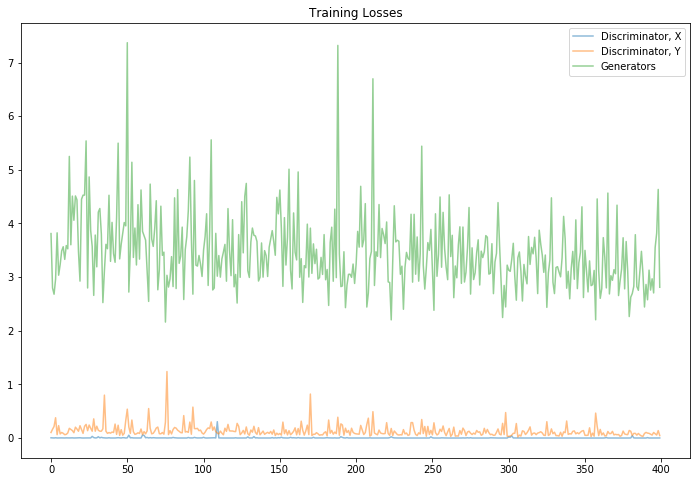

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [39]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


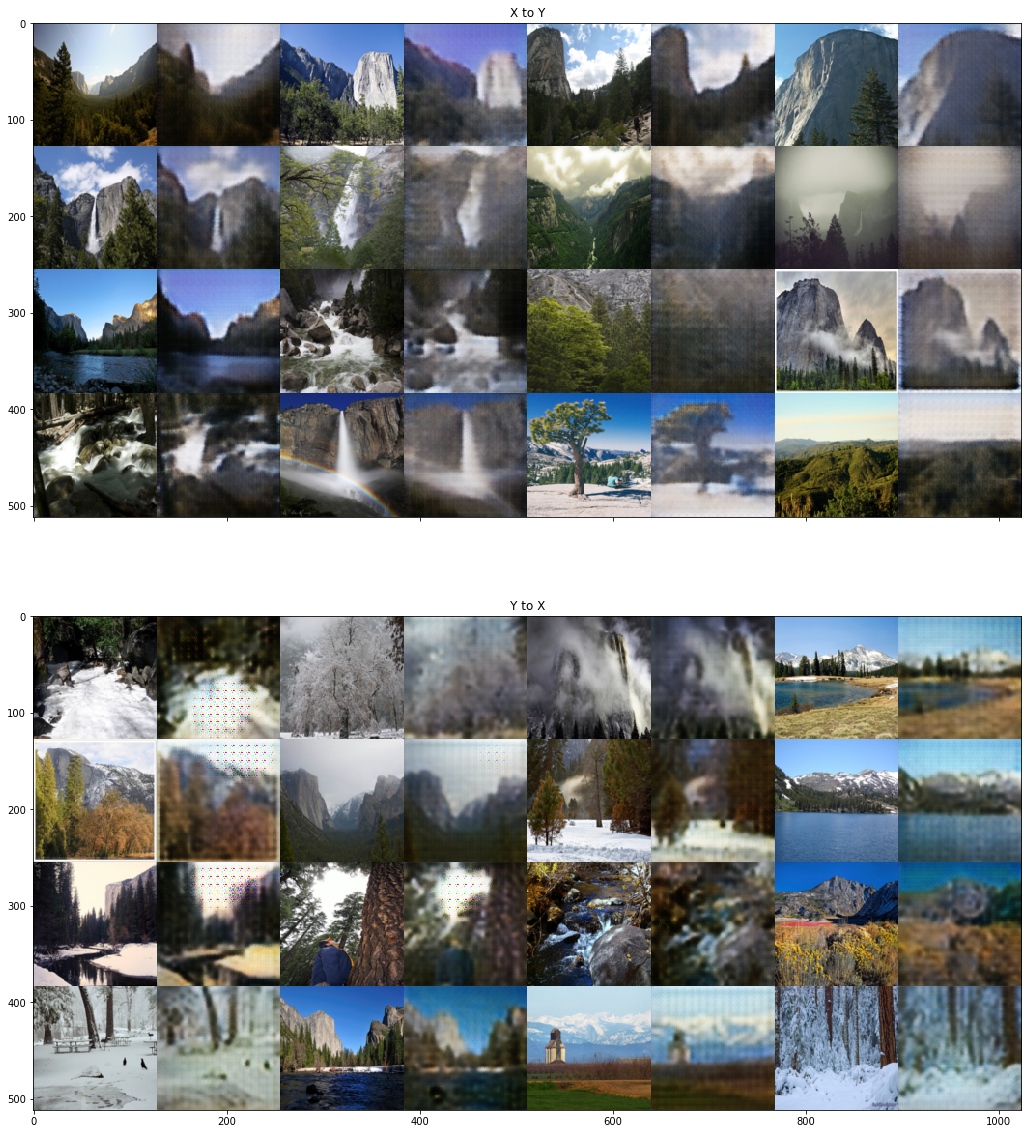

In [40]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

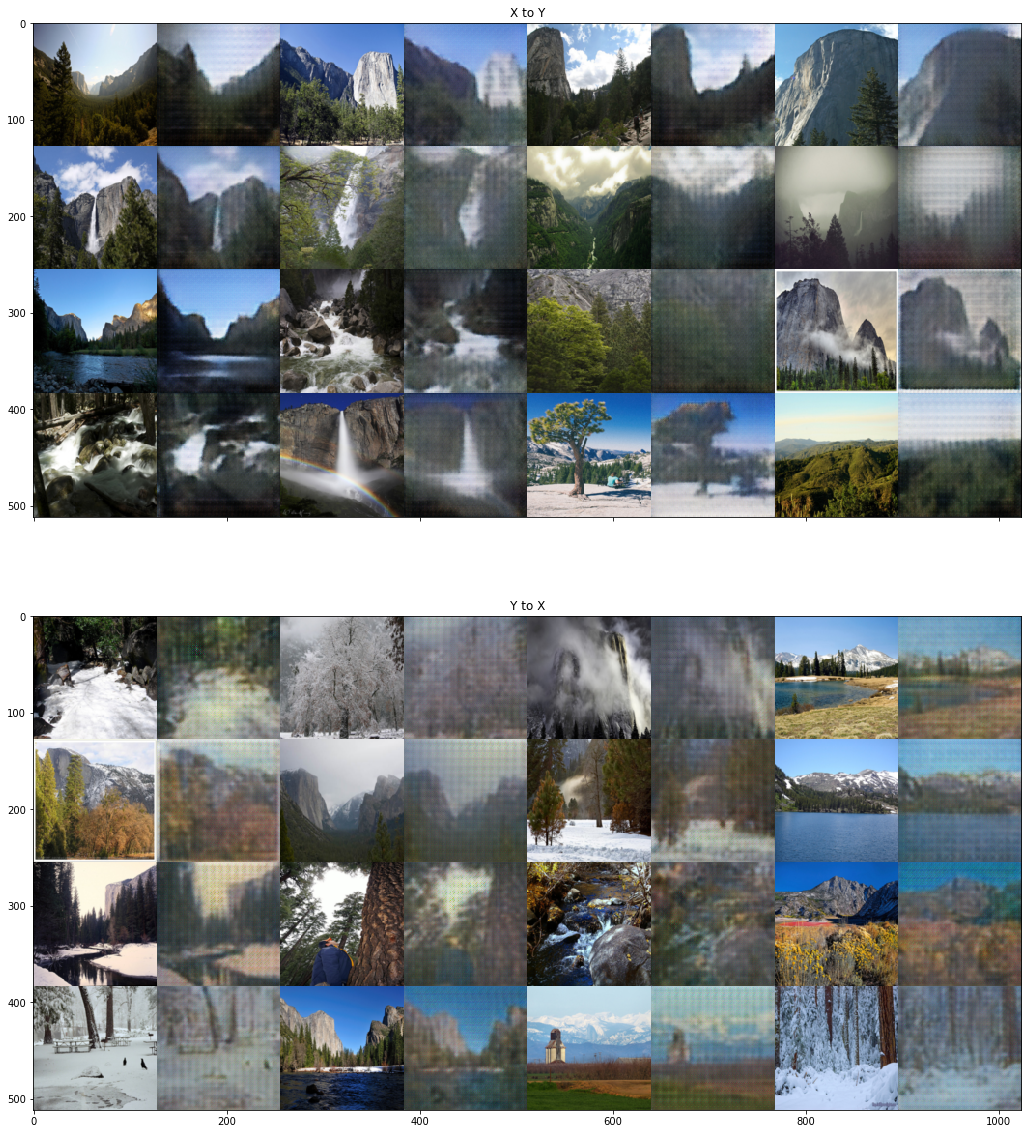

In [41]:
# view samples at iteration 1000
view_samples(4000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.